# LUMI-C cupy + mpi4py benchmarks
The notebook is a continuation of this [LUMI-C OSU mpi4py benchmarks](https://github.com/DeiC-HPC/cotainr/blob/2025.7.1/examples/LUMI/conda_mpi4py_mpich/lumi_mpi4py_osu_results.ipynb) where we first introduce the new open source test methods (containers), then we reproduce the results of the previous notebook.

The OSU benchmarks used are:
- OMB Python MPI Allgather Test: 3 processes, NumPy / CuPy buffers, single and multi node (3 nodes, 1 process each)
- OMB-Py MPI Bandwidth Test: 2 processes, NumPy / CuPy buffers, single and multi node (2 nodes, 1 process each)
- OMB Python MPI Latency Test: 2 processes, NumPy / CuPy buffers, single and multi node (2 nodes, 1 process each)

The test methods are based on two near identical base containers:
- **opensource_base_image_libcxi_libfabric1220_mpich423.sif** with MPICH 4.2.3 and libfabric 1.22.0
- **opensource_base_image_libcxi_libfabric2000_mpich423.sif** with MPICH 4.2.3 and libfabric 2.0

The final container is created using cotainr and these conda environment specifications:
They all contain Python 3.12 and mpich 4.2.3
- **mpi4py_mpich4_pip.yml** pip installed mpi4py version 4.1.0 with conda installed mpich (Most similar to previous experiments)
- **mpi4py_mpich4_conda.yml** conda installed mpi4py version 4.0.3 with conda installed mpich
- **mpi4py_mpich4_ext.yml** conda installed mpi4py version 4.0.3 using external mpich through conda `mpich=external_*`

Note that all Job=lumic runs has been done with `SINGULARITYENV_MPIR_CVAR_ENABLE_GPU=0` so that mpi can initialize without gpu_init.

Finally, this notebook as been run with the `uv` environment described in the `pyproject.toml` and `uv.lock` file.

In [8]:
from pathlib import Path
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme()

In [9]:
# Test setup specification
osu_results_folder = Path("./results/")
tests = {
    "allgather": {"processes": 3, "metric": "Latency (us)", "name": "OMB Python MPI Allgather Test"},
    "bw": {"processes": 2, "metric": "Bandwidth (MB/s)", "name": "OMB-Py MPI Bandwidth Test"},
    "latency": {"processes": 2, "metric": "Latency (us)", "name": "OMB Python MPI Latency Test"},
}
raw_containers = [
    "mpi4py_libfabric2000_extmpich.sif",
    "mpi4py_libfabric1220_extmpich.sif",
    "mpi4py_libfabric2000_pip.sif",
    "mpi4py_libfabric1220_pip.sif",
    "mpi4py_libfabric2000_conda.sif",
    "mpi4py_libfabric1220_conda.sif",
]

# Prettify container names into parameter strings "mpi4py_libfabric1220_pip.sif" -> "mpi4py libfabric1220 pip"
containers = [c.split('.')[0].replace('_', ' ') for c in raw_containers]

In [10]:
# Helper functions
def extract_params_from_file(*, fd: Path, delimiter: str = '-') -> str:
    """
    Parses and extracts parameters from the file name
    
    Args:
        fd (Path): delimiter-separated string ending in .txt
        delimiter (str): default is hyphen '-'

    Returns:
        param_dict (dict): Extracted parameter dictionary
    """
    file_name = fd.name.split('.txt')[0]
    params = file_name.split(delimiter)
    param_dict = {"Slurmid": params[0],
                  "Benchmark": params[1],
                  "Nodes": params[2],
                  "Container": params[3].split('.')[0].replace('_', ' '),
                  "Buffer": params[4]}
    try:
        param_dict['HMEM'] = params[5]
    except:
        param_dict['HMEM'] = 'nohmem'

    try:
        param_dict['Job'] = params[6]
    except:
        param_dict['Job'] = 'lumig'
    return param_dict

In [11]:
def filter_df(df, **kwargs):
    """
    
    """
    for name, value in kwargs.items():
        if name == "Container":
            # string-compare all values to find substring in prettified container names
            # e.g. "libfabric2000" in "mpi4py libfabric2000 conda"
            df = df[[value in str(v) for v in df.values]]
        else:
            df = df[df[name] == value]

    return df

In [12]:
def read_osu_results_file(*, file_path: Path) -> pd.DataFrame:
    """
    Load the actual test/benchmark results from results file.

    Returns
    -------
    df_osu_results : pd.DataFrame
        A long-form pandas dataframe containing the results.

    Notes
    -----
    Assumes that the results file is similar to:

    # OMB Python MPI Allgather Test
    # Size (B)      Latency (us)
    1                       6.81
    2                       6.79
    4                       6.82
    ...

    I.e., it is a fixed with text file, with:
    - two header rows prefixed by "# ": 1. The name of the test, 2. The column names and units
    - a 16 character first column containing integers
    - a 12 character second column containing decimal numbers
    """
    with file_path.open(mode="r") as f:
        test_name = f.readline().removeprefix("# ").strip()
        column = f.readline().removeprefix("# ").strip()
        column_names = re.split(r"\s{2,}", column)
    osu_colspecs = [(0, 16), (16, 29)]
    osu_dtypes = {column_names[0]: "int64", column_names[1]: "float64"}
    df_osu_results = pd.read_fwf(
        file_path,
        colspecs=osu_colspecs,
        header=1,
        names=column_names,
        dtype=osu_dtypes,
    )
    params = extract_params_from_file(fd=file_path)
    df_osu_results["Benchmark"] = params['Benchmark']
    df_osu_results["Nodes"] = params['Nodes']
    df_osu_results["Container"] = params['Container']
    #df_osu_results["Buffer"] = params['Buffer']
    #df_osu_results["HMEM"] = params['HMEM']
    df_osu_results["Job"] = params['Job']

    return df_osu_results

In [13]:
def show_osu_pivot_table(
    *, df: pd.DataFrame, metric: str, containers: list[str]
) -> pd.DataFrame:
    """
    Create a pivot table for the OSU results dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        The OSU results dataframe to create a pivot table for.
    metric : str
        The metric used in the OSU benchmark.
    containers : list of str
        The containers in the OSU results dataframe.

    Returns
    -------
    df_pivot: pd.DataFrame
        The pivot table.
    """

    df_pivot = (
        df.pivot(index="Size (B)", columns=["Container", "Nodes", "Job"], values=[metric])
        .reindex(columns=containers, level="Container")
        .reindex(columns=["single", "multi"], level="Nodes")
    #    .reindex(columns=["numpy", "cupy"], level="Buffer")
    )
    return df_pivot

In [14]:
def barplot_osu_results(
    *, df: pd.DataFrame, benchmark: str, nodes: str,
) -> mpl.figure.Figure:
    """
    Create a barplot of OSU results dataframe.

    Create a plot of `metric` vs message size with `containers` overlaid and
    single/multi node facetted.

    Parameters
    ----------
    df : pd.DataFrame
        The OSU results dataframe to create a barplot for.
    benchmark : str
        A string signifying either single-node run or multi-node run, "single" or "multi"

    Returns
    -------
    mpl.figure.Figure
        The barplot figure handle.
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))

    palette_colors = sns.color_palette('tab10')
    palette_dict = {container: color for container, color in zip(containers, palette_colors)}
    sns.barplot(
        df,
        x="Size (B)",
        y=tests[benchmark]["metric"],
        hue="Container",
        palette=palette_dict,
        legend="brief",
        ax=ax,
    )
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_yscale("log")
    ax.legend(title="Multiple nodes" if nodes == "multi" else "Single node")

    fig.suptitle(f"LUMI-C OSU {tests[benchmark]["name"]} results - {tests[benchmark]["processes"]} processes")
    fig.tight_layout()

    return fig

In [22]:
# Load the data into a DataFrame with all results concatenated
osu_df = pd.concat(
    [
        read_osu_results_file(file_path=file_path)
        for file_path in osu_results_folder.glob("*lumic*.txt")
    ]
)
osu_df= osu_df.sort_values(by=['Container'])

## CPU Allgather test results

In [23]:
benchmark = "allgather"
print(f"LUMI-C OSU {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(lower is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark),
    metric=tests[benchmark]["metric"],
    containers=containers,
)

LUMI-C OSU OMB Python MPI Allgather Test results - 3 processes
(lower is better)


Latency (us)                                        \
Container mpi4py libfabric2000 extmpich         mpi4py libfabric1220 extmpich   
Nodes                            single   multi                        single   
Job                               lumic   lumic                         lumic   
Size (B)                                                                        
1                                  1.74    6.36                          1.54   
2                                  1.73    6.35                          1.56   
4                                  1.68    6.35                          1.55   
8                                  1.65    6.34                          1.55   
16                                 1.71    6.29                          1.56   
32                                 1.68    6.28                          1.53   
64                                 1.77    6.38                          1.64   
128                                1.74    7.00                          1.65   
256                                1.77    8.85                          1.85   
512                                1.92    9.05                          1.94   
1024                               2.22    9.27                          2.21   
2048                               2.68    9.76                          2.56   
4096                               3.37   10.07                          3.25   
8192                               4.53   16.68                          4.55   
16384                              9.41   18.87                          9.95   
32768                             15.58   19.70                         15.53   
65536                             29.07   29.69                         29.04   
131072                            53.46   32.83                         54.37   
262144                           106.41   49.73                        106.22   
524288                           205.54   89.09                        209.00   
1048576                          410.23  156.96                        411.68   

                                                                              \
Container         mpi4py libfabric2000 pip          mpi4py libfabric1220 pip   
Nodes       multi                   single    multi                   single   
Job         lumic                    lumic    lumic                    lumic   
Size (B)                                                                       
1            6.29                     1.77    35.76                     1.85   
2            6.28                     1.80    35.82                     1.86   
4            6.29                     1.79    35.65                     1.99   
8            6.28                     1.76    35.54                     1.86   
16           6.24                     1.72    35.62                     1.86   
32           6.31                     1.73    35.81                     1.85   
64           6.32                     1.80    35.85                     1.87   
128          6.93                     1.82    35.77                     1.89   
256          8.72                     1.91    69.18                     1.92   
512          8.92                     2.04    70.56                     2.11   
1024         9.11                     2.20    87.88                     2.32   
2048         9.69                     2.77    77.56                     2.87   
4096         9.96                     3.50    80.17                     3.64   
8192        16.53                     4.64    82.53                     4.95   
16384       18.72                     9.75    94.66                     9.85   
32768       19.58                    16.04   144.68                    15.99   
65536       23.58                    30.10   187.61                    29.05   
131072      32.58                    54.81   266.76                    54.99   
262144      50.41                   106.02   407.63                   106.08   


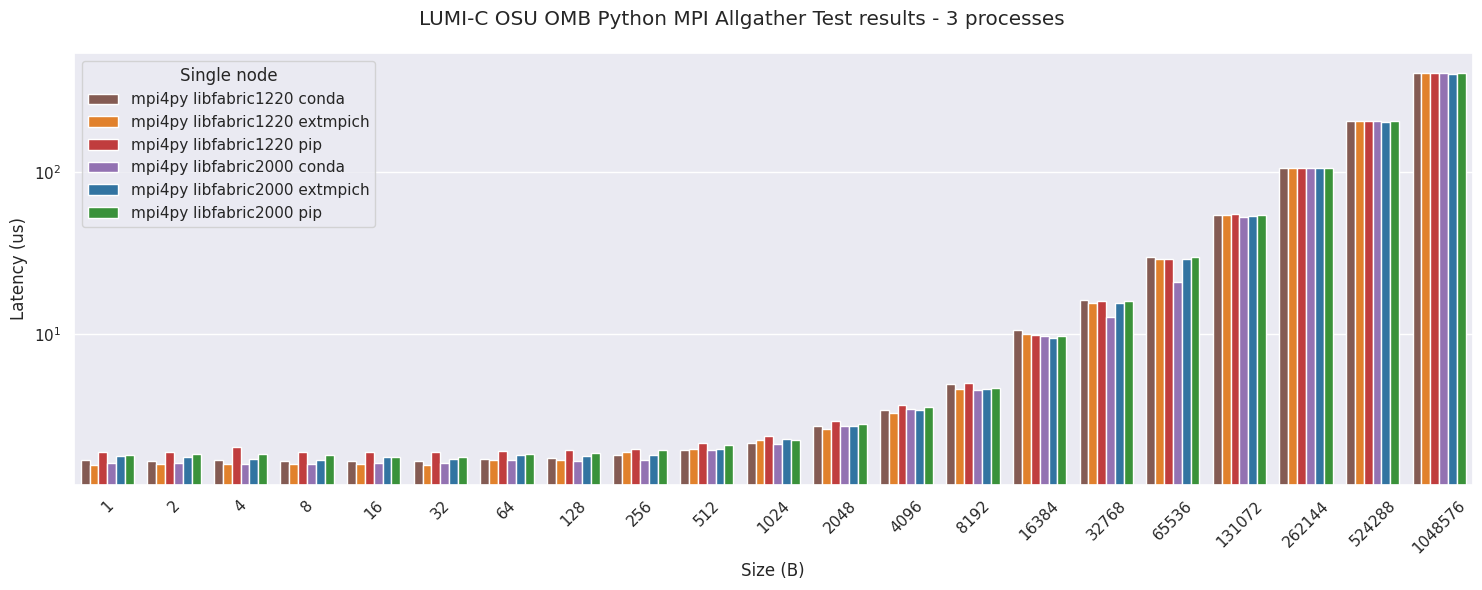

In [24]:
benchmark = "allgather"; nodes = "single"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Nodes=nodes),
    benchmark=benchmark, nodes=nodes
)

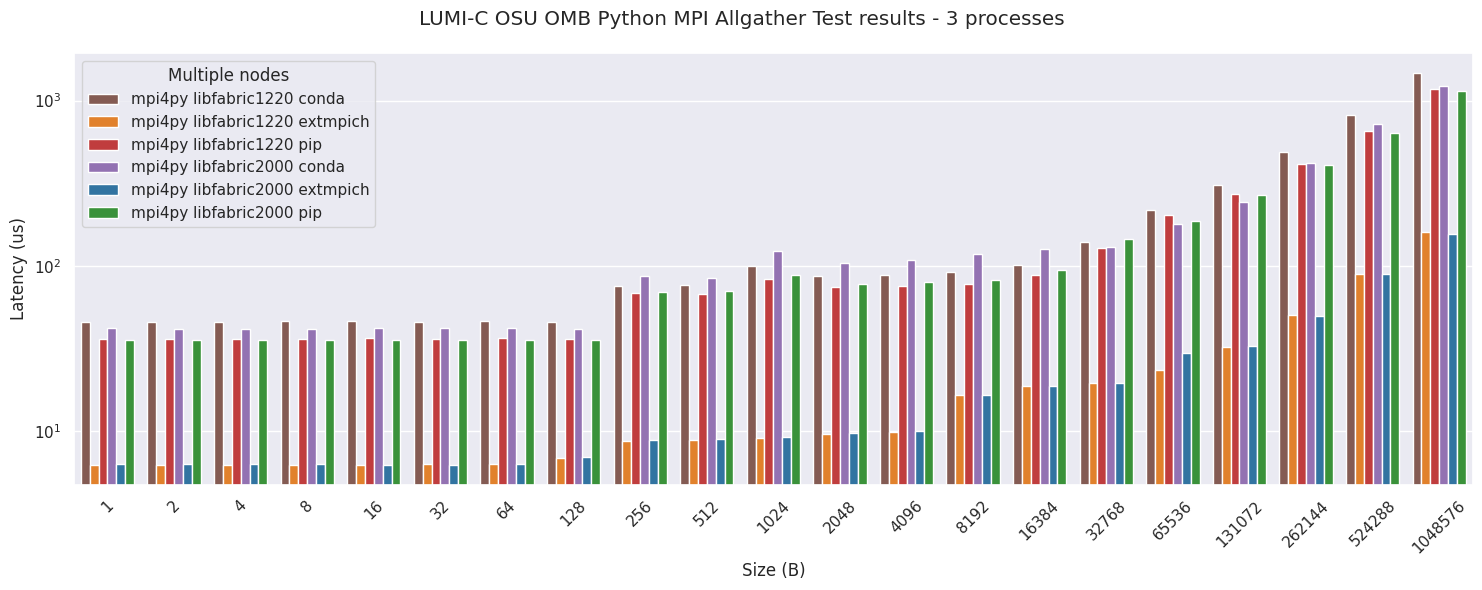

In [25]:
benchmark = "allgather"; nodes = "multi"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Nodes=nodes),
    benchmark=benchmark, nodes=nodes
)

## CPU Bandwith test results

In [26]:
benchmark = "bw"
print(f"LUMI-C OSU {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(higher is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark),
    metric=tests[benchmark]["metric"],
    containers=containers,
)

LUMI-C OSU OMB-Py MPI Bandwidth Test results - 2 processes
(higher is better)


Bandwidth (MB/s)            \
Container mpi4py libfabric2000 extmpich             
Nodes                            single     multi   
Job                               lumic     lumic   
Size (B)                                            
1                                  1.41      1.15   
2                                  2.88      2.29   
4                                  5.74      4.56   
8                                 11.56      9.14   
16                                23.02     18.27   
32                                45.86     36.56   
64                                88.69     73.18   
128                              183.65    146.11   
256                              361.98    297.64   
512                              704.58    595.91   
1024                            1226.39   1155.83   
2048                            1736.03   2383.98   
4096                            2347.09   4727.32   
8192                            2932.10   9008.82   
16384                           2967.79  17886.30   
32768                           3462.53  20733.51   
65536                           3547.38  22396.82   
131072                          3722.76  23179.24   
262144                          3722.65  23626.96   
524288                          4229.20  23835.10   
1048576                         6911.78  23942.16   
2097152                         7155.76  23988.87   
4194304                         7262.64  24025.26   

                                                                            \
Container mpi4py libfabric1220 extmpich           mpi4py libfabric2000 pip   
Nodes                            single     multi                   single   
Job                               lumic     lumic                    lumic   
Size (B)                                                                     
1                                  1.42      1.23                     1.27   
2                                  2.87      2.45                     2.58   
4                                  5.79      4.89                     5.11   
8                                 11.56      9.81                    10.31   
16                                22.47     19.62                    20.71   
32                                45.67     39.25                    41.54   
64                                86.51     76.43                    82.46   
128                              184.49    157.25                   168.32   
256                              347.15    293.34                   332.07   
512                              698.69    585.77                   628.77   
1024                            1212.08   1170.61                  1159.67   
2048                            1647.43   2345.46                  1611.51   
4096                            2326.36   4673.29                  2264.06   
8192                            3339.10   8807.87                  2747.11   
16384                           2914.61  17502.62                  2757.42   
32768                           3181.57  20813.02                  3128.02   
65536                           3394.30  22418.90                  3464.49   
131072                          3612.25  23178.21                  3697.03   
262144                          3786.67  23633.71                  6880.95   
524288                          4142.06  23846.63                  7022.77   
1048576                         4415.87  23952.41                  7083.30   
2097152                         4268.47  24006.56                  7127.18   
4194304                         4282.22  24038.62                  7163.29   

                                                      \
Container          mpi4py libfabric1220 pip            
Nodes        multi                   single    multi   
Job          lumic                    lumic    lumic   
Size (B)                                               
1             0.17                     1.29     0.09   
2             0.3

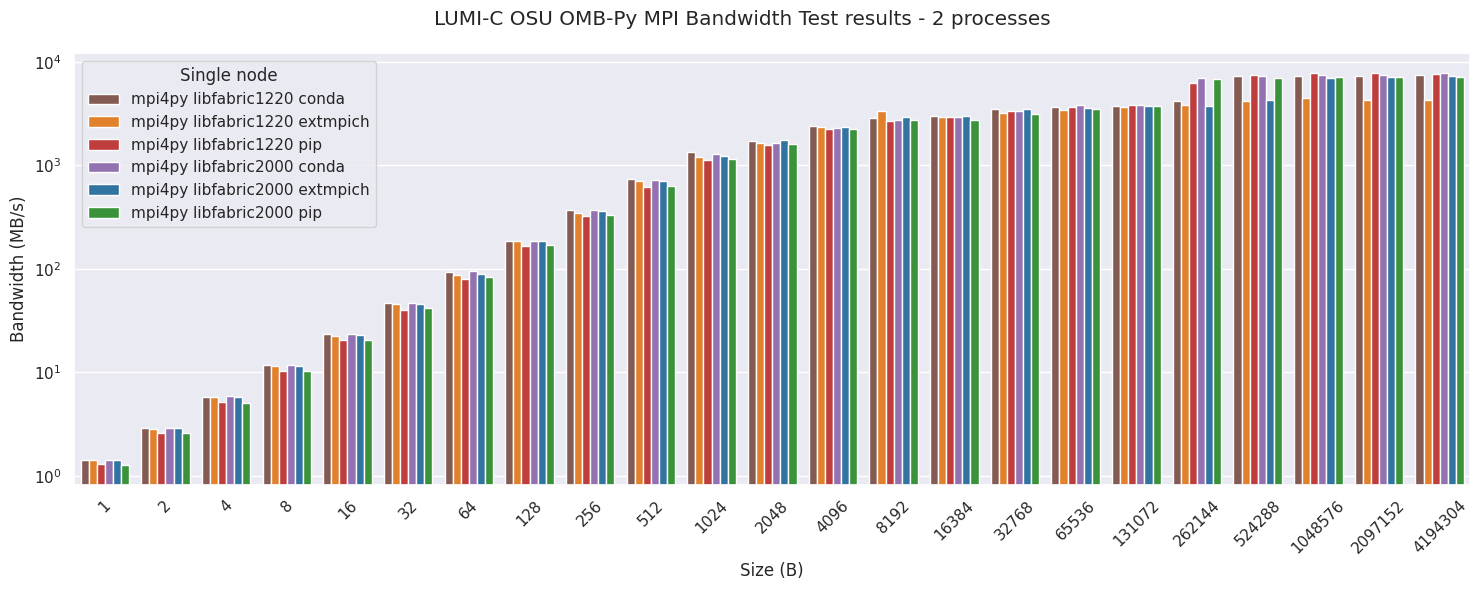

In [27]:
benchmark = "bw"; nodes = "single"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Nodes=nodes),
    benchmark=benchmark, nodes=nodes
)

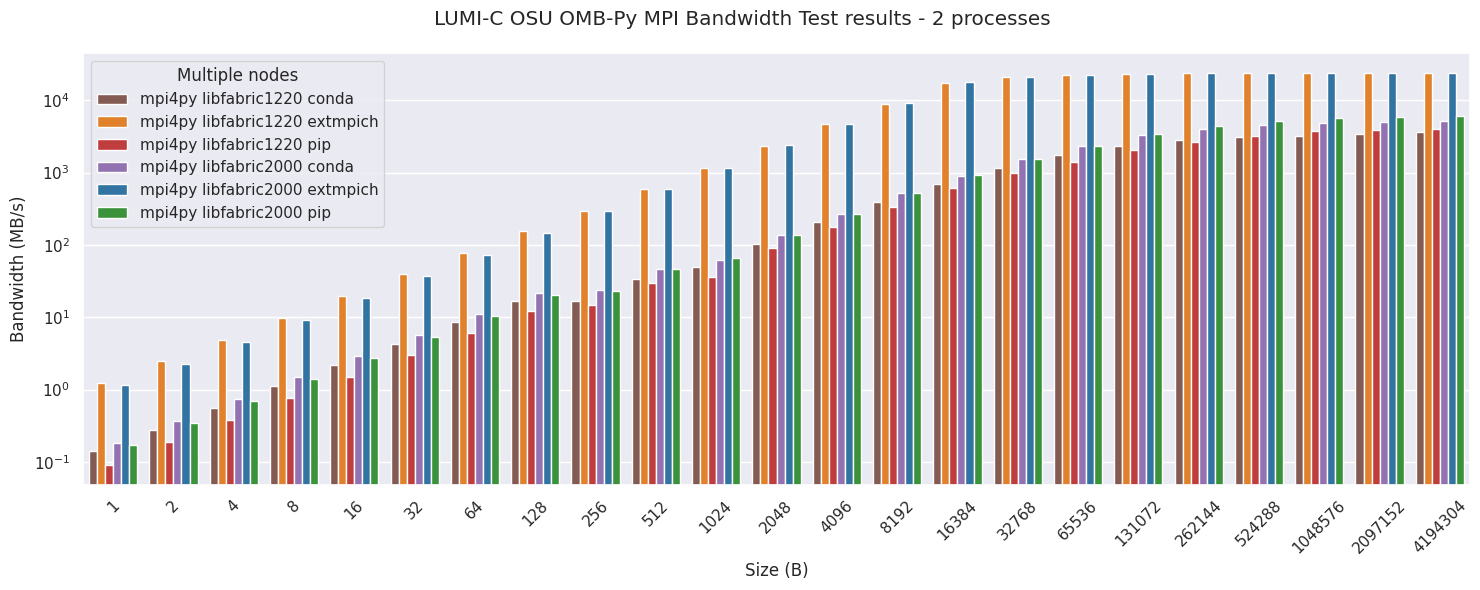

In [28]:
benchmark = "bw"; nodes = "multi"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Nodes=nodes),
    benchmark=benchmark, nodes=nodes
)

## CPU Latency test results

In [29]:
benchmark = "latency"
print(f"LUMI-C OSU {tests[benchmark]['name']} results - {tests[benchmark]['processes']} processes")
print("(lower is better)")
show_osu_pivot_table(
    df=filter_df(osu_df, Benchmark=benchmark),
    metric=tests[benchmark]["metric"],
    containers=containers,
)

LUMI-C OSU OMB Python MPI Latency Test results - 2 processes
(lower is better)


Latency (us)                                        \
Container mpi4py libfabric2000 extmpich         mpi4py libfabric1220 extmpich   
Nodes                            single   multi                        single   
Job                               lumic   lumic                         lumic   
Size (B)                                                                        
0                                  1.04    2.04                          1.04   
1                                  1.12    2.12                          1.11   
2                                  1.13    2.12                          1.11   
4                                  1.14    2.13                          1.12   
8                                  1.13    2.12                          1.11   
16                                 1.13    2.12                          1.14   
32                                 1.14    2.12                          1.11   
64                                 1.23    2.12                          1.24   
128                                1.19    2.71                          1.16   
256                                1.26    2.81                          1.37   
512                                1.45    2.84                          1.60   
1024                               1.72    2.94                          1.79   
2048                               2.04    3.08                          2.03   
4096                               2.68    3.20                          2.68   
8192                               3.48    5.46                          3.54   
16384                              7.32    5.79                          7.50   
32768                              9.06    6.47                          9.56   
65536                             12.51    7.83                         12.45   
131072                            24.10   10.55                         22.29   
262144                            72.95   15.94                         67.79   
524288                           142.87   26.77                        144.25   
1048576                          281.23   48.54                        217.95   
2097152                          551.86   92.10                        426.25   
4194304                         1041.35  179.07                        871.88   

                                                                              \
Container         mpi4py libfabric2000 pip          mpi4py libfabric1220 pip   
Nodes       multi                   single    multi                   single   
Job         lumic                    lumic    lumic                    lumic   
Size (B)                                                                       
0            2.06                     1.27    18.16                     1.27   
1            2.13                     1.35    18.16                     1.36   
2            2.13                     1.44    18.17                     1.36   
4            2.13                     1.38    18.18                     1.35   
8            2.12                     1.36    18.18                     1.34   
16           2.12                     1.36    18.23                     1.37   
32           2.13                     1.31    18.17                     1.34   
64           2.13                     1.35    18.50                     1.38   
128          2.67                     1.33    18.21                     1.36   
256          2.79                     1.42    22.93                     1.42   
512          2.83                     1.61    25.55                     1.63   
1024         2.91                     1.76    28.72                     1.77   
2048         3.06                     2.24    26.79                     2.22   
4096         3.18                     2.87    27.87                     2.95   
8192         5.40                     3.72    28.73                     4.18   
16384        5.77                     7.97    31.74                     8.19 

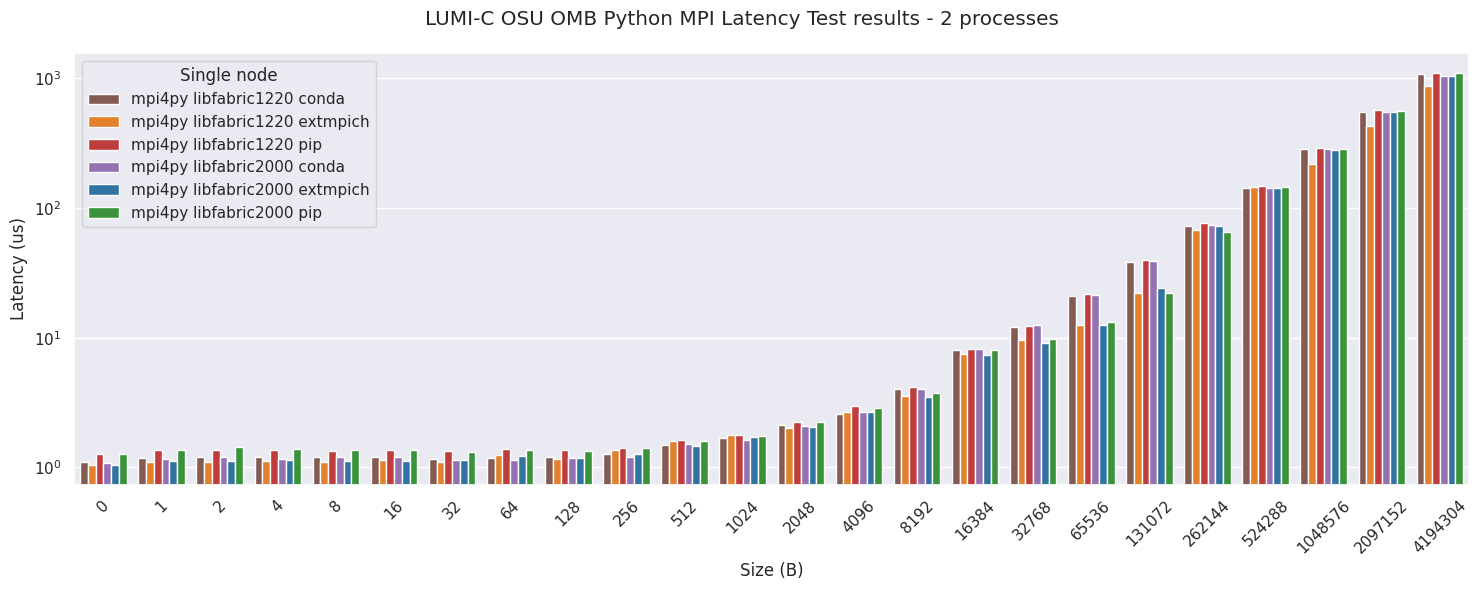

In [30]:
benchmark = "latency"; nodes = "single"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Nodes=nodes),
    benchmark=benchmark, nodes=nodes
)

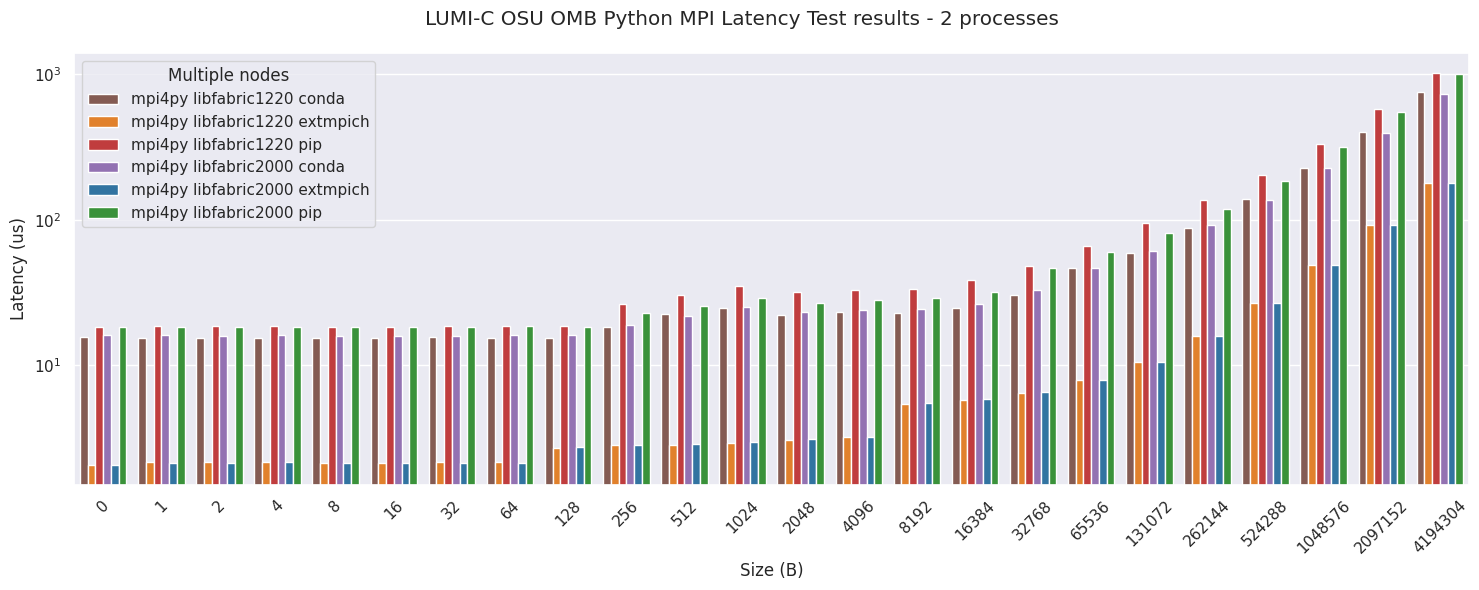

In [31]:
benchmark = "latency"; nodes = "multi"
fig_allgather = barplot_osu_results(
    df=filter_df(osu_df, Benchmark=benchmark, Nodes=nodes),
    benchmark=benchmark, nodes=nodes
)